## CountVectorizer

In [90]:
## Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
import pickle
import re

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB ,GaussianNB
from sklearn.metrics import accuracy_score, classification_report

**The models that we are going to use here:**

- LogisticRegressionCV
- MultinomialNB
- BernoulliNB
- KNN Classifier
- RandomForest Classifier
- AdaBoost Classifier
- SVM Classifier

In [91]:
## Load the data
df= pd.read_csv('../data/human_ai.csv')

In [92]:
df.head()

,text,generated
0,"Y'all, the point isn't that they confirmed tha...",0
1,Who would willingly live in a super long priso...,0
2,"For those unfamiliar, tobacco is a plant that ...",0
3,I think there’s missing information in that he...,0
4,"Great news. The war against nuclear power, fun...",0


In [93]:
df.shape

(12412, 2)

## Removing non english words in answer

In [94]:
df['text'].shape

(12412,)

In [95]:
Text = [df['text'][i] for i in range(len(df['text']))]

In [136]:
## Cleaning function Kalpa:
def clean_the_text(text_1):  #input should be a series
    ## Remove URLs
    new_text_1 = []
    for j in range(len(text_1)):
        result = re.sub(r'http[s]?://\S+', '', text_1[j])
        new_text_1.append(result)
    
    ## Remove non-english 
    new_text_2 = []
    for j in range(len(new_text_1)):
        result = re.sub(r'[^a-zA-Z\s]', '', new_text_1[j])
        new_text_2.append(result)
    
    return "".join(new_text_2) 

In [137]:
clean_the_text(Text[0])

'Yall the point isnt that they confirmed that broad shoulders are attractive The idea is to figure out why and how that works neurologically We really dont have a finely detailed understanding of how the brain works and anything we can learn about it will contribute to all of neurology'

In [138]:
cleaned_text = [clean_the_text(i) for i in Text]

In [139]:
df['cleaned_text'] = cleaned_text

In [140]:
df.head()

,text,generated,cleaned_text
0,"Y'all, the point isn't that they confirmed tha...",0,Yall the point isnt that they confirmed that b...
1,Who would willingly live in a super long priso...,0,Who would willingly live in a super long priso...
2,"For those unfamiliar, tobacco is a plant that ...",0,For those unfamiliar tobacco is a plant that i...
3,I think there’s missing information in that he...,0,I think theres missing information in that hea...
4,"Great news. The war against nuclear power, fun...",0,Great news The war against nuclear power funde...


In [141]:
df.shape

(12412, 3)

# Identify nulls 

In [142]:
df.isna().sum()

text            0
generated       0
cleaned_text    0
dtype: int64

In [143]:
## Already removed nulls during the data cleaning process. (refer the Dataframe for modeling notebook)

In [144]:
## define X and y
X = pd.Series(df['cleaned_text'])
y = df['generated']

In [145]:
# Dataset size

In [146]:
X.shape, y.shape

((12412,), (12412,))

In [147]:
#check the baseline score
y.value_counts(normalize=True)

generated
0    0.5
1    0.5
Name: proportion, dtype: float64

# Top 20 Occurring Words (Only for Human Response)

In [148]:
# Retreive human only answers after removing non english words

In [149]:
human = df[df['generated'] == 0]

In [150]:
human = pd.Series(human['cleaned_text'])

In [151]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()
# Transform the corpus.
human = cvec.fit_transform(human)

In [152]:
human_features = cvec.get_feature_names_out()

In [153]:
# Convert X_train into a DataFrame.

human_df = pd.DataFrame(human.todense(), 
                          columns=human_features)

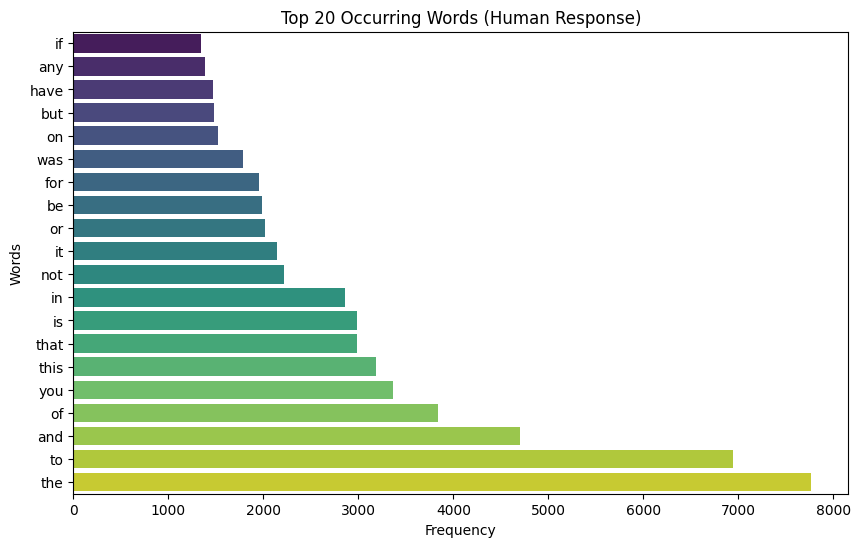

In [154]:
# Sort and select the top 20 occurring words
top_words = human_df.sum().sort_values().tail(20)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')

# Add labels and a title
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Occurring Words (Human Response)')

# Show the plot
plt.show()

# Top 20 Occurring Words (Only for AI Response)

In [155]:
ai = df[df['generated'] == 1]

In [156]:
ai = pd.Series(ai['cleaned_text'])

In [157]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()
# Transform the corpus.
ai = cvec.fit_transform(ai)

In [158]:
ai_features = cvec.get_feature_names_out()

In [159]:
# Convert ai into a DataFrame.

ai_df = pd.DataFrame(ai.todense(), 
                          columns=ai_features)

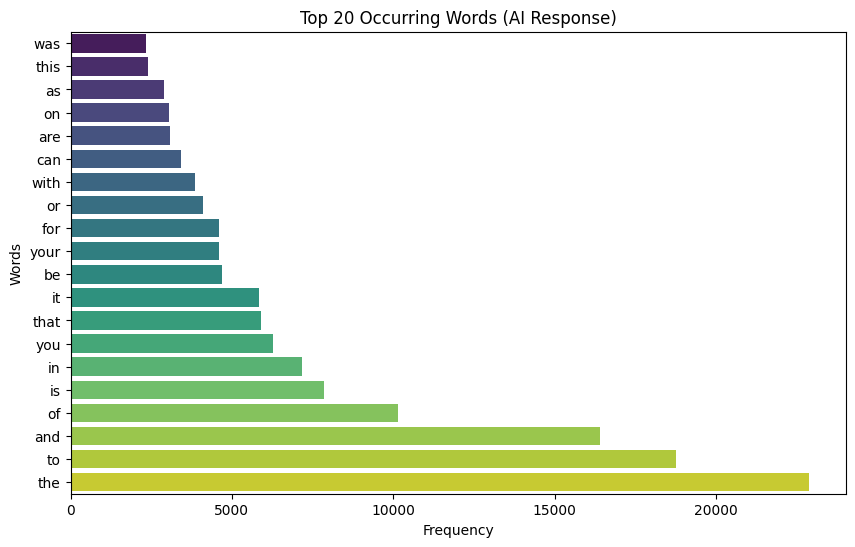

In [160]:
# Sort and select the top 20 occurring words
top_words = ai_df.sum().sort_values().tail(20)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')

# Add labels and a title
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Occurring Words (AI Response)')

# Show the plot
plt.show()

In [161]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Instantiate a CountVectorizer.

In [162]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()
# Transform the corpus.
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

In [163]:
columns=cvec.get_feature_names_out()

In [164]:
# Convert X_train into a DataFrame.

X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names_out())

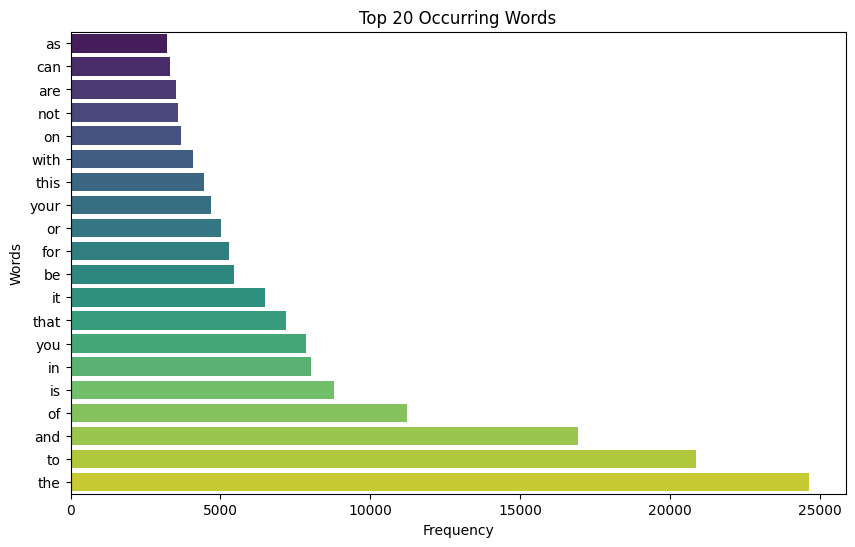

In [165]:
# Sort and select the top 20 occurring words when considering both the human and ai responses
top_words = X_train_df.sum().sort_values().tail(20)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')

# Add labels and a title
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Occurring Words')


#plt.savefig("./img/Cvec/Top_20_Occurring_Words.jpg", dpi=300)
# Show the plot
plt.show()

### Redefine training and testing sets.

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [167]:
columns

array(['aaa', 'aardvark', 'aaron', ..., 'zuvorkommend', 'zw', 'zyn'],
      dtype=object)

In [168]:
english_stopwords = stopwords.words('english')

## Function for model evaluation

In [169]:
def evaluation(name_of_the_model ,y_test,preds,gs_model):
    ## find the confusion matrix
    cm = confusion_matrix(y_test,preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Accuracy, Sensitivity, Specificity, and Precision
    #Accuracy = round((tp + tn) /(tp + tn + fn + fp),3)
    Sensitivity = round(tp/(tp+fn),3)
    Specificity = round(tn/(tn+fp),3)
    Precision = round(tp / (tp + fp),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test,y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' :name_of_the_model,
        'Score on train':train_score ,
        'Score on test': test_score,
         'Sensitivity':Sensitivity,
         'Specificity':Specificity,
         'Precision' : Precision
        },index=[0]
    )

    return df #Display the dataframe

In [170]:
## Function for plotting the confusion matrix

In [171]:
def plot_confusion(y_test,preds,gs_model):
    return ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds, labels=gs_model.classes_), 
                              display_labels=['Human[0]','AI[1]']).plot();

# LogisticRegressionCV

In [172]:
# Let's set a pipeline up with two stages:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(max_iter=5000,solver = 'lbfgs'))
])

In [173]:
pipe_params_logr = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [5],#[3,5]
    'cvec__max_df' : [0.9],#0.95],
    'cvec__ngram_range' : [(1,2)],#(1,1)],
    'cvec__stop_words' : [ None, 'english'],
    #'logr__solver': ['lbfgs', 'liblinear'],
    #'logr__penalty' : ['l1', 'l2']
}

In [174]:
# Instantiate GridSearchCV for LogisticRegressionCV
gs_logr = GridSearchCV(pipe_logr,     # what object are we optimizing?
                  pipe_params_logr,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [175]:
# Fit GridSearch to training data.
gs_logr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(max_iter=5000))]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [176]:
gs_logr.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [177]:
# Get predictions
preds_logr = gs_logr.predict(X_test)

In [178]:
logr = evaluation('logr',y_test,preds_logr,gs_logr)
logr

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,logr,0.962,0.903,0.854,0.948,0.939


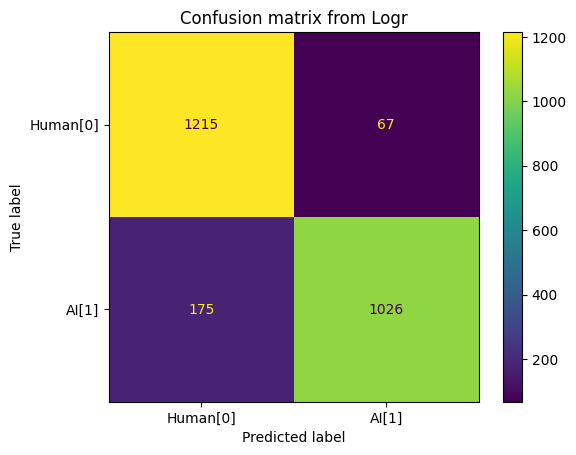

In [180]:
plot_confusion(y_test,preds_logr,gs_logr);
plt.title('Confusion matrix from Logr');
#plt.savefig("./img/Cvec/Confusion_matrix_from_Logr.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model.

# RandomForestClassifier

In [181]:
# Let's set a pipeline up with two stages:
pipe_rfc = Pipeline([
    ('cvec', CountVectorizer()),
    ('rfc', RandomForestClassifier())
])

In [182]:
pipe_params_rfc = {
    'cvec__max_features' : [5000],#2000, 3000, 4000, 5000],
    'cvec__min_df' : [5], #[3,5]
    'cvec__max_df' : [0.9], #[0.9,0.95]
    'cvec__ngram_range' : [(1,2)], #[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english']
}

In [183]:
# Instantiate GridSearchCV for RandomForestClassifier
gs_rfc = GridSearchCV(pipe_rfc,     # what object are we optimizing?
                  pipe_params_rfc,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [184]:
# Fit GridSearch to training data.
gs_rfc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [185]:
gs_rfc.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [186]:
# Get predictions
preds_rfc = gs_rfc.predict(X_test)

In [187]:
Randomfc=evaluation('Randomfc',y_test,preds_rfc,gs_rfc)
Randomfc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,Randomfc,0.996,0.884,0.866,0.901,0.891


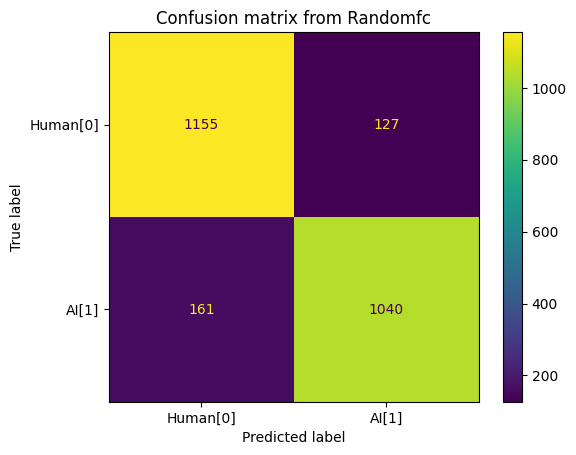

In [188]:
plot_confusion(y_test,preds_rfc,gs_rfc);
plt.title('Confusion matrix from Randomfc');
#plt.savefig("./img/Cvec/Confusion_matrix_from_Randomfc.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model.

# KNN Classifier

In [189]:
# Let's set a pipeline up with two stages:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [190]:
pipe_params_knn = {
    'cvec__max_features' : [2000],#, 3000, 4000, 5000],
    'cvec__min_df' : [5],#[3,5]
    'cvec__max_df' : [0.9],#[0.9,0.95]
    'cvec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english'],
    'knn__n_neighbors' : [3]#[3,4,5,6,7,8,9,10]
}

In [191]:
# Instantiate GridSearchCV for KNN Classifier
gs_knn = GridSearchCV(pipe_knn,     # what object are we optimizing?
                  pipe_params_knn,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [192]:
# Fit GridSearch to training data.
gs_knn.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [2000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'knn__n_neighbors': [3]})

In [193]:
gs_knn.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'knn__n_neighbors': 3}

In [194]:
# Get predictions
preds_knn = gs_knn.predict(X_test)

In [195]:
knn = evaluation('KNN',y_test,preds_knn,gs_knn)
knn

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,KNN,0.877,0.808,0.701,0.909,0.878


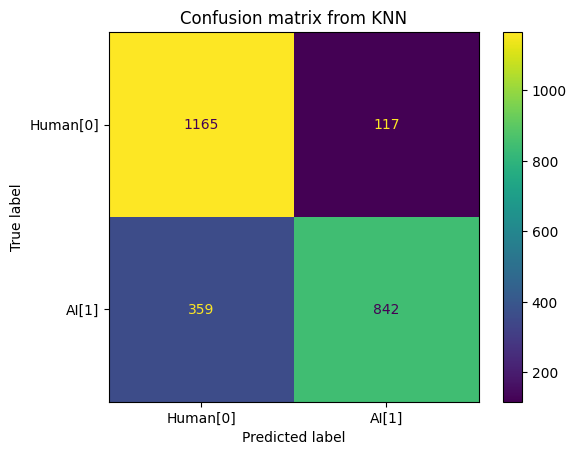

In [196]:
plot_confusion(y_test,preds_knn,gs_knn);
plt.title('Confusion matrix from KNN');
#plt.savefig("./img/Cvec/Confusion_matrix_from_KNN.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model. However, compared to the models above, there is a significantly high number of false negatives, which is proven by the lower sensitivity of the model.

# MultinomialNB

In [197]:
# Let's set a pipeline up with two stages:
pipe_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [198]:
pipe_params_mnb = {
    'cvec__max_features' : [5000],#2000, 3000, 4000, 5000],
    'cvec__min_df' : [5],#[3,5]
    'cvec__max_df' : [0.9],#[0.9,0.95]
    'cvec__ngram_range' : [(1,1)],#[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english']
}

In [199]:
# Instantiate GridSearchCV for MultinomialNB
gs_mnb = GridSearchCV(pipe_mnb,     # what object are we optimizing?
                  pipe_params_mnb,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [200]:
# Fit GridSearch to training data.
gs_mnb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None, 'english']})

In [201]:
gs_mnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [202]:
# Get predictions
preds_mnb = gs_mnb.predict(X_test)

In [203]:
mnb = evaluation('MultinomialNB',y_test,preds_mnb,gs_mnb)
mnb

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,MultinomialNB,0.842,0.819,0.884,0.757,0.773


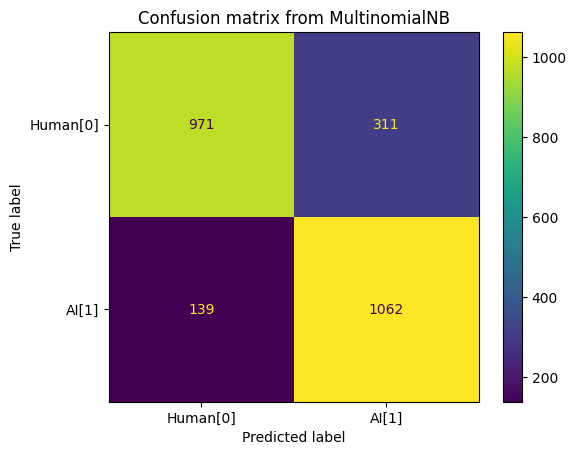

In [204]:
plot_confusion(y_test,preds_mnb,gs_mnb);
plt.title('Confusion matrix from MultinomialNB');
#plt.savefig("./img/Cvec/Confusion_matrix_from_MultinomialNB.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model. However, compared to the models above, there is a significantly high number of false positives, which is proven by the lower specificity of the model.

# BernoulliNB

In [205]:
# Let's set a pipeline up with two stages:
pipe_bnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [206]:
pipe_params_bnb = {
    'cvec__max_features' : [5000],#2000, 3000, 4000, 5000],
    'cvec__min_df' : [5],#[3,5]
    'cvec__max_df' : [0.9],#[0.9,0.95]
    'cvec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english']
}

In [207]:
# Instantiate GridSearchCV for BernoulliNB
gs_bnb = GridSearchCV(pipe_bnb,     # what object are we optimizing?
                  pipe_params_bnb,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [208]:
# Fit GridSearch to training data.
gs_bnb.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [209]:
gs_bnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [210]:
# Get predictions
preds_bnb = gs_bnb.predict(X_test)

In [211]:
bnb=evaluation('BernoulliNB',y_test,preds_bnb,gs_bnb)
bnb

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,BernoulliNB,0.881,0.863,0.834,0.891,0.877


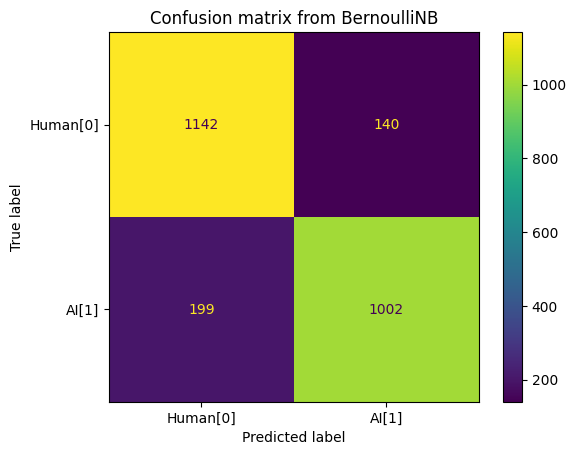

In [212]:
plot_confusion(y_test,preds_bnb,gs_bnb);
plt.title('Confusion matrix from BernoulliNB');
#plt.savefig("./img/Cvec/Confusion_matrix_from_BernoulliNB.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model.

# AdaBoostClassifier

In [213]:
# Let's set a pipeline up with two stages:
pipe_abc = Pipeline([
    ('cvec', CountVectorizer()),
    ('abc', AdaBoostClassifier())
])

In [214]:
pipe_params_abc = {
    'cvec__max_features' : [3000],#2000, 3000, 4000, 5000],
    'cvec__min_df' : [3],#[3,5]
    'cvec__max_df' : [0.9],#[0.9,0.95]
    'cvec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english'],
    'abc__n_estimators' : [100,200,300]
}

In [215]:
# Instantiate GridSearchCV for AdaBoostClassifier
gs_abc = GridSearchCV(pipe_abc,     # what object are we optimizing?
                  pipe_params_abc,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [216]:
# Fit GridSearch to training data.
gs_abc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('abc', AdaBoostClassifier())]),
             param_grid={'abc__n_estimators': [100, 200, 300],
                         'cvec__max_df': [0.9], 'cvec__max_features': [3000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [217]:
gs_abc.best_params_

{'abc__n_estimators': 300,
 'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [218]:
# Get predictions
preds_abc = gs_abc.predict(X_test)

In [219]:
gs_abc.best_params_

{'abc__n_estimators': 300,
 'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [220]:
abc = evaluation('AdaBoostClassifier',y_test,preds_abc,gs_abc)
abc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,AdaBoostClassifier,0.925,0.883,0.843,0.92,0.909


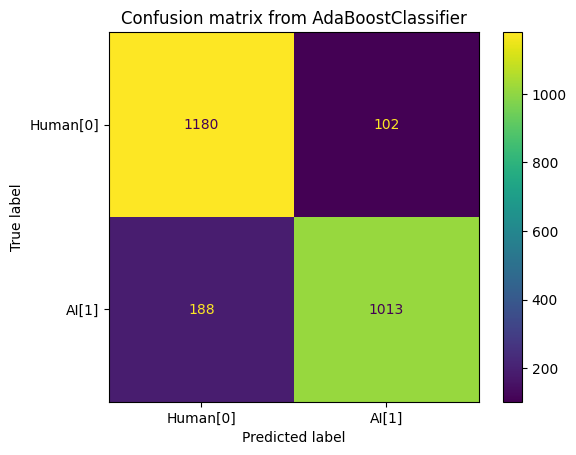

In [221]:
plot_confusion(y_test,preds_abc,gs_abc);
plt.title('Confusion matrix from AdaBoostClassifier');
#plt.savefig("./img/Cvec/Confusion matrix from AdaBoostClassifier.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model.

# LinearSVC

In [222]:
# Let's set a pipeline up with two stages:
pipe_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', LinearSVC())
])

In [223]:
pipe_params_svc = {
    'cvec__max_features' : [4000],#2000, 3000, 4000, 5000],
    'cvec__min_df' : [5],#[3,5]
    'cvec__max_df' : [0.9],#[0.9,0.95]
    'cvec__ngram_range' : [(1,2)],#[(1,1),(1,2)]
    'cvec__stop_words' : [ None, 'english'],
    'svc__C' : np.linspace(0.0001, 1, 5)
}

In [224]:
# Instantiate GridSearchCV for LinearSVC
gs_svc = GridSearchCV(pipe_svc,     # what object are we optimizing?
                  pipe_params_svc,   # what parameters values are we searching?
                  cv=5)               # 5-fold cross-validation.

In [225]:
# Fit GridSearch to training data.
gs_svc.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', LinearSVC())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [5], 'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'svc__C': array([1.00000e-04, 2.50075e-01, 5.00050e-01, 7.50025e-01, 1.00000e+00])})

In [226]:
gs_svc.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'svc__C': 0.250075}

In [227]:
# Get predictions
preds_svc = gs_svc.predict(X_test)

In [228]:
svc = evaluation('LinearSVC',y_test,preds_svc,gs_svc)
svc

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision
0,LinearSVC,0.982,0.892,0.85,0.931,0.921


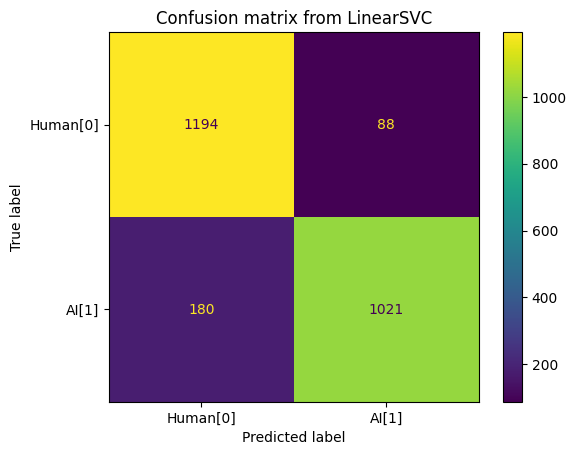

In [229]:
plot_confusion(y_test,preds_svc,gs_svc);
plt.title('Confusion matrix from LinearSVC');
#plt.savefig("./img/Cvec/Confusion_matrix_from_LinearSVC.jpg", dpi=300)

From the confusion matrix, we see that the true positives and true negatives are significantly higher compared to the false positives and the false negatives, which means the model can predict the AI texts more accurately and is confirmed from the above evaluation table for the model when looking at the sensitivity, specificity, and precision of the model.

### Illustrate all scores in one table

In [230]:
Table = pd.concat([logr,Randomfc,knn,mnb,bnb,abc,svc],ignore_index=True)

In [231]:
Table.set_index('Model')

,Score on train,Score on test,Sensitivity,Specificity,Precision
Model,,,,,
logr,0.962,0.903,0.854,0.948,0.939
Randomfc,0.996,0.884,0.866,0.901,0.891
KNN,0.877,0.808,0.701,0.909,0.878
MultinomialNB,0.842,0.819,0.884,0.757,0.773
BernoulliNB,0.881,0.863,0.834,0.891,0.877
AdaBoostClassifier,0.925,0.883,0.843,0.920,0.909
LinearSVC,0.982,0.892,0.850,0.931,0.921


# Identify the best model

In [234]:
# Pickle the best fitted pipeline
with open('../models/logr.pkl', 'wb') as f:
    pickle.dump(gs_logr.best_estimator_, f)

**Ref: The idea for the model evaluation function and for the confusion matrix display function was taken from the GA lecture notebooks.**